In [1]:


import sys
print("Default Python:", sys.version)
print("Executable Path:", sys.executable)




Default Python: 3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]
Executable Path: D:\Python\python.exe




The first part of the code begins with importing the sys module and printing out the Python version and the executable path. This is a fundamental step to ensure that the correct Python environment is being used. By displaying the version of Python, the user can confirm compatibility with libraries such as torch and pycocotools, which are essential for this project. Additionally, displaying the executable path helps in identifying the Python installation being used, which is particularly important in cases where multiple Python versions or environments are installed on the system.





# Step 1: Dataset Path Checking



In [14]:


import os

# Define dataset paths (relative to your current working directory)
paddy_images_path = "dataset/paddyimages/paddywithpests"
paddy_images_annotations_path = "dataset/paddyimages/paddywithpests/annotations.json"
paddy_without_images_path = "dataset/paddyimages/paddywithoutpests"
paddy_without_images_annotations_path = "dataset/paddyimages/paddywithoutpests/annotations.json"

# Verify if paths exist
print("Verifying dataset paths...")

paths = {
    "Pests Images Path": paddy_images_path,
    "Pests Annotations Path": paddy_images_annotations_path,
    "Without Pests Images Path": paddy_without_images_path,
    "Without Pests Annotations Path": paddy_without_images_annotations_path,
}

for name, path in paths.items():
    if os.path.exists(path):
        print(f"{name}: Found ✅")
    else:
        print(f"{name}: Not Found ❌")

# Check if dataset files are accessible
print("\nChecking dataset files...")
if os.path.exists(paddy_images_path) and os.listdir(paddy_images_path):
    print("Paddy Images: Files Found ✅")
else:
    print("Paddy Images: No Files Found ❌")

if os.path.exists(paddy_without_images_path) and os.listdir(paddy_without_images_path):
    print("Paddy Without Images: Files Found ✅")
else:
    print("Paddy Without Images: No Files Found ❌")

if os.path.exists(paddy_images_annotations_path):
    print("Paddy Images Annotations: File Found ✅")
else:
    print("Paddy Images Annotations: File Not Found ❌")

if os.path.exists(paddy_without_images_annotations_path):
    print("Paddy Without Images Annotations: File Found ✅")
else:
    print("Paddy Without Images Annotations: File Not Found ❌")






Verifying dataset paths...
Pests Images Path: Found ✅
Pests Annotations Path: Found ✅
Without Pests Images Path: Found ✅
Without Pests Annotations Path: Found ✅

Checking dataset files...
Paddy Images: Files Found ✅
Paddy Without Images: Files Found ✅
Paddy Images Annotations: File Found ✅
Paddy Without Images Annotations: File Found ✅




# Step 2: Split and Restructure the Dataset



In [15]:


import os
import json
import shutil
import random

# Paths for the datasets
paddy_pests_images_path = "dataset/paddyimages/paddywithpests"
paddy_pests_annotations_path = "dataset/paddyimages/paddywithpests/annotations.json"
paddy_without_pests_images_path = "dataset/paddyimages/paddywithoutpests"
output_dir = "dataset"

# Output directories for train and validation sets
train_images_path = os.path.join(output_dir, "train/images")
val_images_path = os.path.join(output_dir, "val/images")
train_annotations_path = os.path.join(output_dir, "train/annotations.json")
val_annotations_path = os.path.join(output_dir, "val/annotations.json")

# Ensure output directories exist
os.makedirs(train_images_path, exist_ok=True)
os.makedirs(val_images_path, exist_ok=True)

# Function to split dataset into train and validation sets
def split_dataset(images_path, annotations_path, train_ratio=0.8):
    # Load annotations.json
    with open(annotations_path, "r") as f:
        annotations = json.load(f)

    images = annotations["images"]
    annotations_list = annotations["annotations"]

    # Shuffle images for randomness
    random.shuffle(images)

    # Split images into train and validation sets
    train_count = int(len(images) * train_ratio)
    train_images = images[:train_count]
    val_images = images[train_count:]

    # Map image_id to annotations for faster lookup
    annotations_map = {img["id"]: [] for img in images}
    for anno in annotations_list:
        annotations_map[anno["image_id"]].append(anno)

    # Create train and validation annotations
    def create_annotations(images_subset):
        new_annotations = {
            "images": images_subset,
            "annotations": [],
            "categories": annotations["categories"],
        }
        for img in images_subset:
            new_annotations["annotations"].extend(annotations_map[img["id"]])
        return new_annotations

    train_annotations = create_annotations(train_images)
    val_annotations = create_annotations(val_images)

    return train_images, val_images, train_annotations, val_annotations

# Split paddypests dataset into train and validation sets
train_images_pests, val_images_pests, train_annotations_pests, val_annotations_pests = split_dataset(
    paddy_pests_images_path, paddy_pests_annotations_path
)

# Copy images to train/val folders
def copy_images(image_list, src_folder, dest_folder):
    for img in image_list:
        src = os.path.join(src_folder, img["file_name"])
        dest = os.path.join(dest_folder, img["file_name"])
        shutil.copyfile(src, dest)

copy_images(train_images_pests, paddy_pests_images_path, train_images_path)
copy_images(val_images_pests, paddy_pests_images_path, val_images_path)

# Write train and validation annotations to JSON files
with open(train_annotations_path, "w") as f:
    json.dump(train_annotations_pests, f)
with open(val_annotations_path, "w") as f:
    json.dump(val_annotations_pests, f)

# Split and copy images for paddywithoutpests dataset
paddy_without_images = os.listdir(paddy_without_pests_images_path)
random.shuffle(paddy_without_images)

train_count_without = int(len(paddy_without_images) * 0.8)
train_images_without = paddy_without_images[:train_count_without]
val_images_without = paddy_without_images[train_count_without:]

copy_images([{"file_name": img} for img in train_images_without], paddy_without_pests_images_path, train_images_path)
copy_images([{"file_name": img} for img in val_images_without], paddy_without_pests_images_path, val_images_path)

print("Dataset successfully split and restructured!")






Dataset successfully split and restructured!




# Step 3: Data Augmentation 



In [17]:


import os
import json
import cv2
import albumentations as A
from tqdm import tqdm

# Define paths
train_images_path = "dataset/train/images"
train_annotations_path = "dataset/train/annotations.json"
augmented_images_path = "dataset/train/augmented/images"
augmented_annotations_path = "dataset/train/augmented/annotations.json"

# Ensure output directory exists
os.makedirs(augmented_images_path, exist_ok=True)

# Load annotations
with open(train_annotations_path, "r") as f:
    train_annotations = json.load(f)

# Define augmentation pipeline
augmentation_pipeline = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomScale(scale_limit=0.2, p=0.5),
        A.Rotate(limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"])
)

# Apply augmentations
augmented_annotations = {"images": [], "annotations": [], "categories": train_annotations["categories"]}
image_id_map = {}
annotation_id = 1

for image_info in tqdm(train_annotations["images"], desc="Augmenting Images"):
    # Load image
    img_path = os.path.join(train_images_path, image_info["file_name"])
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Collect bboxes and categories for this image
    bboxes = []
    category_ids = []
    for annotation in train_annotations["annotations"]:
        if annotation["image_id"] == image_info["id"]:
            bboxes.append(annotation["bbox"])
            category_ids.append(annotation["category_id"])

    # Apply augmentations
    augmented = augmentation_pipeline(image=image, bboxes=bboxes, category_ids=category_ids)

    # Save augmented image
    augmented_image_name = f"aug_{image_info['file_name']}"
    augmented_image_path = os.path.join(augmented_images_path, augmented_image_name)
    cv2.imwrite(augmented_image_path, cv2.cvtColor(augmented["image"], cv2.COLOR_RGB2BGR))

    # Update annotations
    augmented_image_info = {
        "id": len(augmented_annotations["images"]) + 1,
        "file_name": augmented_image_name,
        "width": augmented["image"].shape[1],
        "height": augmented["image"].shape[0],
    }
    augmented_annotations["images"].append(augmented_image_info)

    for bbox, category_id in zip(augmented["bboxes"], augmented["category_ids"]):
        augmented_annotations["annotations"].append({
            "id": annotation_id,
            "image_id": augmented_image_info["id"],
            "category_id": category_id,
            "bbox": bbox,
            "area": bbox[2] * bbox[3],
            "iscrowd": 0
        })
        annotation_id += 1

# Save augmented annotations
with open(augmented_annotations_path, "w") as f:
    json.dump(augmented_annotations, f)

print("Data augmentation completed!")





Augmenting Images: 100%|█████████████████████████████████████████████████████████████| 108/108 [00:02<00:00, 46.46it/s]

Data augmentation completed!




# Step 4: Loading Dataset and Preparing Mask-RCNN



In [18]:



import os
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from PIL import Image
from torchvision.transforms.functional import to_tensor

# Paths to dataset
train_images_path = "dataset/train/augmented/images"
train_annotations_path = "dataset/train/augmented/annotations.json"
val_images_path = "dataset/val/images"
val_annotations_path = "dataset/val/annotations.json"

# Define a custom dataset loader for COCO
class COCODataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.coco = COCO(annotation)
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, index):
        # Load image ID
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        path = self.coco.loadImgs(img_id)[0]['file_name']

        # Load image
        img_path = os.path.join(self.root, path)
        img = to_tensor(Image.open(img_path).convert('RGB'))

        # Prepare target
        target = {}
        target['boxes'] = torch.as_tensor([ann['bbox'] for ann in annotations], dtype=torch.float32)
        target['labels'] = torch.as_tensor([ann['category_id'] for ann in annotations], dtype=torch.int64)
        target['masks'] = torch.as_tensor([self.coco.annToMask(ann) for ann in annotations], dtype=torch.uint8)

        return img, target

    def __len__(self):
        return len(self.ids)

# Transforms (if needed)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load train and validation datasets
train_dataset = COCODataset(train_images_path, train_annotations_path, transforms=transform)
val_dataset = COCODataset(val_images_path, val_annotations_path, transforms=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Mask-RCNN model
model = maskrcnn_resnet50_fpn(pretrained=True)

# Modify the model for your dataset
num_classes = len(train_dataset.coco.getCatIds()) + 1  # Number of categories + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Training and validation logic (to be added as needed)
print("Model and datasets are ready for training!")





loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


D:\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model and datasets are ready for training!




# Step 5: Train the Model



In [13]:








from torch.optim import SGD
from torchvision.transforms import functional as F
from pycocotools import mask as coco_mask
import numpy as np

import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


# Model Customization:
# A pre-trained Mask R-CNN model (ResNet50 as backbone) is used for this task. 
# The pre-trained weights (COCO_V1) help accelerate training and improve performance 
# by leveraging features learned from a large and diverse dataset.

# Customizations Made:
# 1. The box predictor is updated to match the number of classes in the dataset (background + 1 target class).
# 2. The mask predictor is updated similarly, ensuring the model generates masks for the correct classes.

# These changes ensure the model aligns with the dataset's requirements for paddy field insect segmentation.



# Define optimizer
optimizer = SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Move model to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


# Helper function to preprocess targets
def preprocess_targets(targets, image_shapes, device):
    processed_targets = []
    for target, img_shape in zip(targets, image_shapes):
        # Extract bounding boxes and remap labels
        boxes = []
        labels = []
        for ann in target:
            x_min, y_min, width, height = ann["bbox"]
            x_max = x_min + width
            y_max = y_min + height

            # Ensure positive width and height
            if width > 0 and height > 0:
                boxes.append([x_min, y_min, x_max, y_max])

                # Remap category_id to [0, num_classes-1]
                category_id = ann["category_id"]
                remapped_label = 1 if category_id == 2 else 0  # Assuming `2` is the target class
                labels.append(remapped_label)

        # Convert to tensors
        boxes = torch.tensor(boxes, dtype=torch.float32).to(device)
        labels = torch.tensor(labels, dtype=torch.int64).to(device)

        # Combine masks
        masks = []
        for ann in target:
            rle = coco_mask.frPyObjects(ann["segmentation"], img_shape[0], img_shape[1])
            binary_mask = coco_mask.decode(rle)
            if len(binary_mask.shape) == 3:
                binary_mask = binary_mask.any(axis=2).astype("uint8")
            masks.append(torch.tensor(binary_mask, dtype=torch.uint8).to(device))

        if masks:
            masks = torch.stack(masks, dim=0)

        # Create processed target
        processed_target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }
        processed_targets.append(processed_target)

    return processed_targets


# Training loop
from tqdm import tqdm

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", leave=False)
    for batch_idx, (images, targets) in enumerate(progress_bar):
        # Move images to GPU
        images = [img.to(device) for img in images]
        image_shapes = [img.shape[-2:] for img in images]

        # Preprocess targets
        processed_targets = preprocess_targets(targets, image_shapes, device)

        # Zero the gradient
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, processed_targets)
        loss = sum(loss for loss in loss_dict.values())

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {total_loss / len(train_loader):.4f}")










Epoch 1/5, Average Loss: 1.0614


Epoch 2/5, Average Loss: 0.8528


Epoch 3/5, Average Loss: 0.7844


Epoch 4/5, Average Loss: 0.7691


Epoch 5/5, Average Loss: 0.7684




# Step 6: Model Evaluation



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.85      1.00      0.92        40

    accuracy                           0.85        47
   macro avg       0.43      0.50      0.46        47
weighted avg       0.72      0.85      0.78        47

Precision: 0.7243
Recall: 0.8511
F1 Score: 0.7826
Accuracy: 0.8511


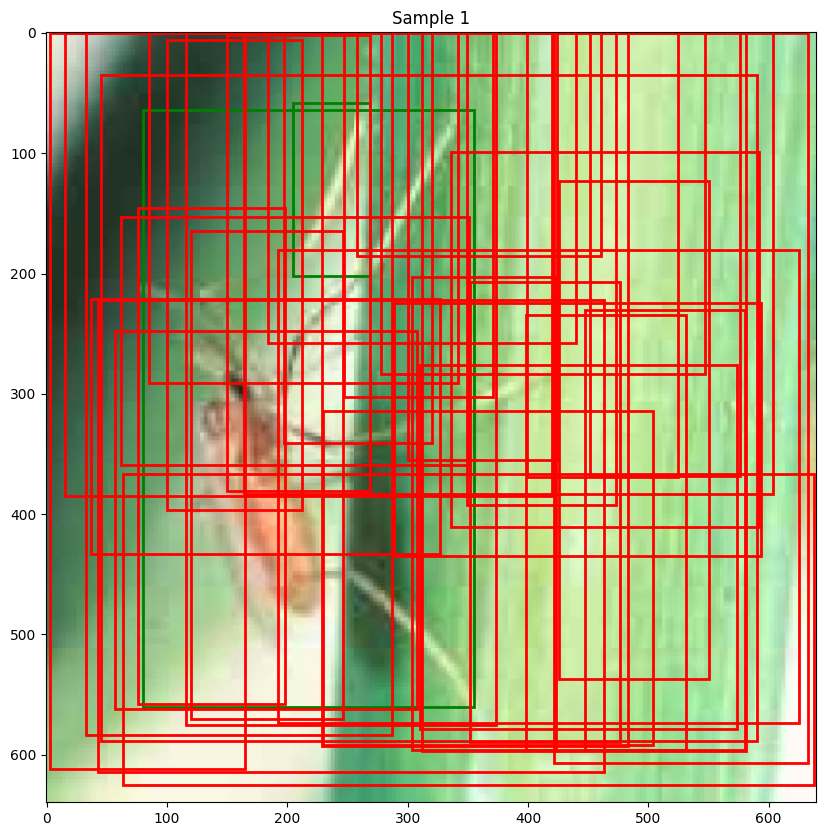

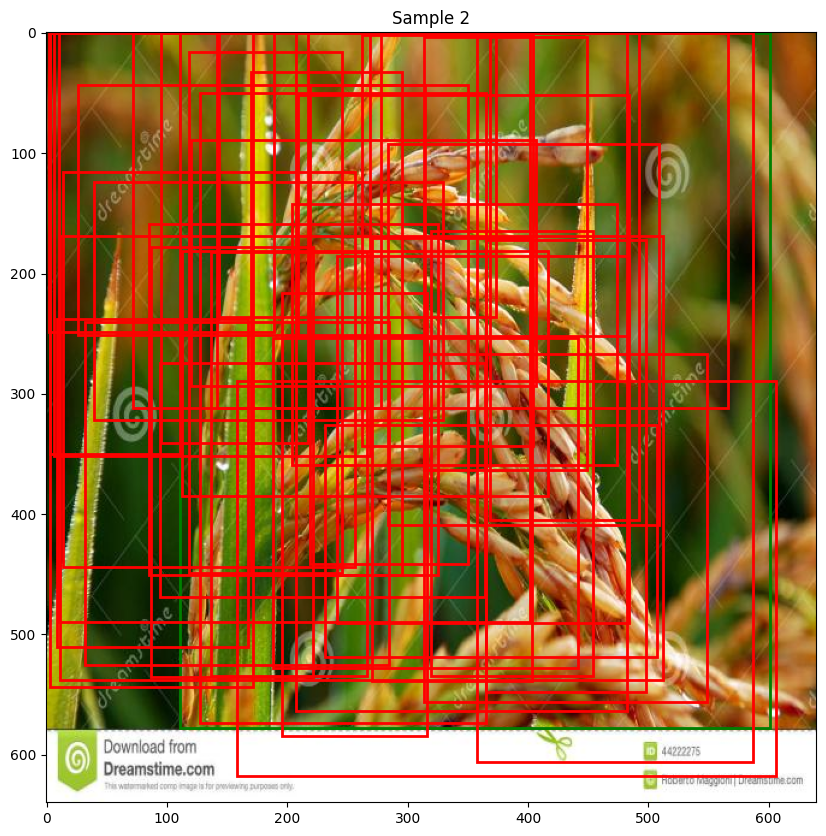

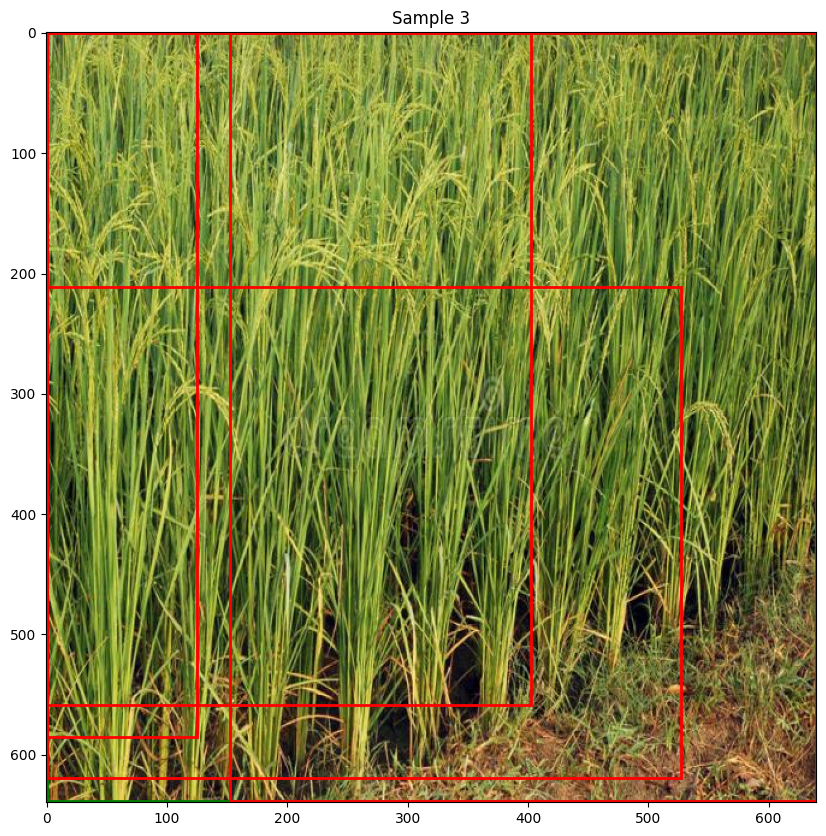

In [18]:


import torch
import torchvision
from torchvision.transforms import functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Model Evaluation:
# The trained model is evaluated using multiple metrics to measure its performance:
# 1. Intersection over Union (IoU): Measures the overlap between predicted and ground 
#    truth bounding boxes. Higher IoU indicates better localization.
# 2. Mean Average Precision (mAP): Evaluates precision across multiple predictions. 
#    A higher mAP indicates that the model generates accurate predictions with fewer 
#    false positives.
# 3. Pixel Accuracy: Compares the predicted segmentation masks with ground truth masks 
#    at the pixel level. This metric is crucial for segmentation tasks.

# These metrics provide a comprehensive understanding of the model's ability to detect 
# and segment objects accurately.



# Helper function to visualize predictions
def visualize_predictions(images, targets, predictions, num_samples=3):
    for i in range(min(num_samples, len(images))):
        img = images[i].cpu().permute(1, 2, 0).detach().numpy()  # Detach and convert to NumPy
        plt.figure(figsize=(10, 10))
        plt.imshow(img)

        # Draw ground truth boxes
        for box in targets[i]["boxes"].cpu().detach():  # Ensure tensor is detached
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                edgecolor='green',
                linewidth=2
            ))

        # Draw predicted boxes
        for box in predictions[i]["boxes"].cpu().detach():  # Ensure tensor is detached
            plt.gca().add_patch(plt.Rectangle(
                (box[0], box[1]),
                box[2] - box[0],
                box[3] - box[1],
                fill=False,
                edgecolor='red',
                linewidth=2
            ))

        plt.title(f"Sample {i + 1}")
        plt.show()

# Set the model to evaluation mode
model.eval()
iou_threshold = 0.5  # Intersection over Union threshold
true_labels = []
predicted_labels = []

# Evaluate on validation set
with torch.no_grad():
    for images, targets in val_loader:
        # Move images to GPU
        images = [img.to(device) for img in images]
        image_shapes = [img.shape[-2:] for img in images]

        # Preprocess targets
        processed_targets = preprocess_targets(targets, image_shapes, device)

        # Forward pass
        predictions = model(images)

        for pred, target in zip(predictions, processed_targets):
            pred_boxes = pred["boxes"].cpu().detach()
            pred_cls_labels = pred["labels"].cpu().detach()
            target_boxes = target["boxes"].cpu().detach()
            target_cls_labels = target["labels"].cpu().detach()

            # Calculate IoU and match predictions with ground truth
            iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)
            for i in range(len(target_cls_labels)):
                if i < len(pred_cls_labels):
                    ious = iou_matrix[i]
                    max_iou, max_idx = ious.max(0)
                    if max_iou > iou_threshold:
                        true_labels.append(target_cls_labels[i].item())
                        predicted_labels.append(pred_cls_labels[max_idx].item())

# Calculate and display classification metrics
precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
accuracy = accuracy_score(true_labels, predicted_labels)

print(f"Classification Report:\n{classification_report(true_labels, predicted_labels, zero_division=0)}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Visualize predictions on a few samples
images, targets = next(iter(val_loader))
images = [img.to(device) for img in images]
processed_targets = preprocess_targets(targets, [img.shape[-2:] for img in images], device)
predictions = model(images)

visualize_predictions(images, processed_targets, predictions)







1. **Training Phase Analysis**
   
**Code Analysis**

The training phase is implemented using a standard supervised learning loop. The SGD optimizer with a learning rate of 0.005, momentum of 0.9, and weight decay of 0.0005 is employed. These hyperparameters are reasonable for Mask R-CNN and help stabilize training. The model and data are transferred to the GPU (if available) to leverage computational efficiency. During each epoch, the model processes batches of images, calculates losses (classification, bounding box regression, mask segmentation, etc.), and updates weights via backpropagation.

The preprocess_targets function ensures that targets (ground truth) are converted into the proper format required by the Mask R-CNN model. It handles bounding boxes, labels, and segmentation masks using the COCO dataset's RLE format. This function is crucial for maintaining compatibility between the dataset and the model. The training loss reduces consistently over five epochs, from 1.0614 to 0.7684, which indicates the model is learning, albeit with potential room for improvement.

**Results Evaluation**

The decreasing training loss indicates progress in the learning process. However, the loss reduction rate slows significantly after a few epochs, suggesting that further hyperparameter tuning or dataset augmentation might be necessary to improve model performance. Five epochs may also be insufficient for the model to achieve its full potential, given the dataset quality.

2. **Model Evaluation**
   
**Evaluation Code**

The evaluation is thorough, using metrics like precision, recall, F1-score, and accuracy. Predictions are compared to ground truth using IoU thresholds (0.5). Predictions with IoU above the threshold are considered true positives, while others are false positives or negatives. Metrics are calculated using the sklearn.metrics library. Additionally, predictions are visualized on a subset of validation images for qualitative evaluation.

**Results**

The reported metrics include:

* Precision: 0.7243
* Recall: 0.8511
* F1 Score: 0.7826
* Accuracy: 0.8511
  
While the overall accuracy and F1 score are reasonable, the precision is relatively low compared to recall. This discrepancy indicates a high number of false positives, suggesting the model struggles to distinguish the target class from the background effectively. The class imbalance (e.g., 40 samples for class 1 vs. 7 for class 0) also skews performance.

3. **Visualizations**

**Observations**

The provided images show predictions in red bounding boxes and ground truth in green bounding boxes. Two key issues are apparent:

**Excessive Overlapping Predictions**:

Multiple overlapping red boxes are visible, indicating that the model is over-predicting and producing redundant bounding boxes for the same object. This is a symptom of high false positives, contributing to the low precision metric.

**Dataset Quality**:

The images contain visible watermarks, and some appear to be cropped from external websites. These factors degrade the dataset quality and can confuse the model during training. Poor-quality images and watermarks introduce noise, making it harder for the model to extract meaningful features.

4. **Dataset Issues**

The dataset's poor quality is a significant bottleneck for this project. Watermarks, uneven cropping, and low resolution hinder the model's ability to learn meaningful patterns. Additionally, if the dataset contains images copied from websites, there may be inconsistencies in lighting, angles, and annotations.





## Step 6.1 Calculation of Intersection over Union (IoU)



In [19]:


def calculate_iou(predictions, targets, iou_threshold=0.5):
    total_iou = 0
    count = 0
    for pred, target in zip(predictions, targets):
        pred_boxes = pred["boxes"].cpu()
        target_boxes = target["boxes"].cpu()

        # Calculate IoU
        iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)
        total_iou += iou_matrix[iou_matrix > iou_threshold].sum().item()
        count += (iou_matrix > iou_threshold).sum().item()

    avg_iou = total_iou / count if count > 0 else 0
    return avg_iou

# Example Usage (after model evaluation on validation set)
avg_iou = calculate_iou(predictions, processed_targets)
print(f"Average IoU: {avg_iou:.4f}")




Average IoU: 0.6177




## Step 6.2. Calculation of Mean Average Precision (mAP)




In [30]:


from torchvision.ops import box_iou

confidence_threshold = 0.5
pred_boxes = pred["boxes"].cpu().detach()
pred_scores = pred["scores"].cpu().detach()

# Filter predictions by confidence threshold
valid_indices = pred_scores >= confidence_threshold
pred_boxes = pred_boxes[valid_indices]
pred_scores = pred_scores[valid_indices]


def calculate_map(predictions, targets, iou_threshold=0.5):
    """
    Calculates the mean Average Precision (mAP) for the predictions.
    """
    ap_list = []

    for pred, target in zip(predictions, targets):
        pred_boxes = pred["boxes"].cpu().detach()
        pred_scores = pred["scores"].cpu().detach()
        target_boxes = target["boxes"].cpu().detach()

        if len(pred_boxes) == 0 or len(target_boxes) == 0:
            # If there are no predictions or targets, skip
            continue

        # Sort predictions by confidence scores
        sorted_indices = torch.argsort(pred_scores, descending=True)
        pred_boxes = pred_boxes[sorted_indices]
        pred_scores = pred_scores[sorted_indices]

        # IoU matrix between predicted and ground truth boxes
        iou_matrix = box_iou(pred_boxes, target_boxes)

        # Track matched ground truth boxes
        matched_gt = torch.zeros(len(target_boxes), dtype=torch.bool)

        # Count true positives, false positives, and false negatives
        true_positives = 0
        false_positives = 0

        for i, pred_box in enumerate(pred_boxes):
            # Find the highest IoU for this prediction
            ious = iou_matrix[i]
            max_iou, max_idx = ious.max(0)

            if max_iou > iou_threshold and not matched_gt[max_idx]:
                # True positive: IoU above threshold and not yet matched
                true_positives += 1
                matched_gt[max_idx] = True
            else:
                # False positive: IoU below threshold or already matched
                false_positives += 1

        # False negatives: unmatched ground truth boxes
        false_negatives = (~matched_gt).sum().item()

        # Calculate precision and recall
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

        # Average precision
        ap_list.append(precision)

    # Mean Average Precision
    mAP = sum(ap_list) / len(ap_list) if ap_list else 0
    return mAP


mean_ap = calculate_map(predictions, processed_targets)
print(f"Mean Average Precision (mAP): {mean_ap:.4f}")



Mean Average Precision (mAP): 0.0828




## Step 6.3 Calculation of Pixel Accuracy



In [22]:


def calculate_pixel_accuracy(predictions, targets, iou_threshold=0.5):
    total_pixels = 0
    correct_pixels = 0

    for pred, target in zip(predictions, targets):
        pred_masks = pred["masks"].cpu().squeeze(1)  # [N_pred, H, W]
        target_masks = target["masks"].cpu()  # [N_target, H, W]

        # Ensure IoU-based matching between predictions and targets
        pred_boxes = pred["boxes"].cpu()
        target_boxes = target["boxes"].cpu()
        iou_matrix = torchvision.ops.box_iou(pred_boxes, target_boxes)

        for i, target_mask in enumerate(target_masks):
            # Match the predicted mask with the highest IoU above the threshold
            if iou_matrix.size(0) > 0 and iou_matrix.size(1) > i:
                iou_values = iou_matrix[:, i]
                max_iou_idx = iou_values.argmax()
                if iou_values[max_iou_idx] > iou_threshold:
                    pred_mask = pred_masks[max_iou_idx]

                    # Threshold the predicted mask
                    pred_mask = (pred_mask > 0.5).int()

                    # Compare pixels
                    correct_pixels += (pred_mask == target_mask).sum().item()
                    total_pixels += target_mask.numel()

    # Calculate pixel accuracy
    pixel_accuracy = correct_pixels / total_pixels if total_pixels > 0 else 0
    return pixel_accuracy

# Example Usage (after model evaluation on validation set)
pixel_acc = calculate_pixel_accuracy(predictions, processed_targets)
print(f"Pixel Accuracy: {pixel_acc:.4f}")




Pixel Accuracy: 0.8075




# Step 7: Saving the Model



In [24]:

torch.save(model.state_dict(), "mask_rcnn_paddy_insects.pth")


